# Solving a Maze with Deep Reinforcement Learning
# FEEC/Unicamp - July/2020
# Based on https://www.samyzaf.com/ML/rl/qmaze.html

### Importações e definições

In [1]:
from __future__ import print_function
from time import sleep
from IPython import display
import pylab as pl
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painted by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

In [3]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        self.free_cells.remove(self.target)
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.maze.size
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state

        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        valid_actions = self.valid_actions()
                
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        else:                  # invalid action, no change in rat position
            mode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0
        if mode == 'blocked':
            return self.min_reward - 1
        if (rat_row, rat_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)

        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        return actions

In [4]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [ ]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

In [5]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
    [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.]
])

reward= -0.04


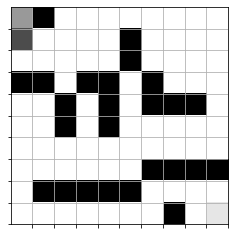

In [6]:
qmaze = Qmaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

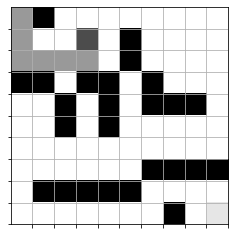

In [7]:
qmaze.act(DOWN)  # move down
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(RIGHT)  # move right
qmaze.act(UP)  # move up
show(qmaze)

In [8]:
def play_game(model, qmaze, rat_cell):
    qmaze.reset(rat_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

In [9]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

In [10]:
class Experience(object):
    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def remember(self, episode):
        # episode = [envstate, action, reward, envstate_next, game_over]
        # memory[i] = episode
        # envstate == flattened 1d maze cells info, including rat cell (see method: observe)
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]   # envstate 1d size (1st element of episode)
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size, replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            # There should be no target values for actions not taken.
            targets[i] = self.predict(envstate)
            # Q_sa = derived policy = max quality env/action = max_a' Q(s', a')
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                # reward + gamma * max_a' Q(s', a')
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [11]:
def qtrain(model, maze, **opt):
    global epsilon
    n_epoch = opt.get('n_epoch', 15000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()

    # If you want to continue training from a previous model,
    # just supply the h5 file name to weights_file option
    if weights_file:
        print("loading weights from file: %s" % (weights_file,))
        model.load_weights(weights_file)

    # Construct environment/game from numpy array: maze (see above)
    qmaze = Qmaze(maze)

    # Initialize experience replay object
    experience = Experience(model, max_memory=max_memory)

    win_history = []   # history of win/lose game
    n_free_cells = len(qmaze.free_cells)
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    imctr = 1

    for epoch in range(n_epoch):
        loss = 0.0
        rat_cell = random.choice(qmaze.free_cells)
        qmaze.reset(rat_cell)
        game_over = False

        # get initial envstate (1d flattened canvas)
        envstate = qmaze.observe()

        n_episodes = 0
        while not game_over:
            valid_actions = qmaze.valid_actions()
            if not valid_actions: break
            prev_envstate = envstate
            # Get next action
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))

            # Apply action, get reward and new envstate
            envstate, reward, game_status = qmaze.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False

            # Store episode (experience)
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.remember(episode)
            n_episodes += 1

            # Train neural network model
            inputs, targets = experience.get_data(data_size=data_size)
            h = model.fit(
                inputs,
                targets,
                epochs=8,
                batch_size=16,
                verbose=0,
            )
            loss = model.evaluate(inputs, targets, verbose=0)

        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
    
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # we simply check if training has exhausted all free cells and if in all
        # cases the agent won
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break

    # Save trained model weights and architecture, this will be used by the visualization code
    h5file = name + ".h5"
    json_file = name + ".json"
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    end_time = datetime.datetime.now()
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

In [12]:
def build_model(maze, lr=0.001):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

In [ ]:
maze =  np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  0.,  1.,  0.],
    [ 0.,  0.,  0.,  1.,  1.,  1.,  0.],
    [ 1.,  1.,  1.,  1.,  0.,  0.,  1.],
    [ 1.,  0.,  0.,  0.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

qmaze = Qmaze(maze)
show(qmaze)

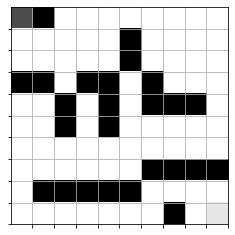

In [13]:
maze2 = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 0.,  0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.],
    [ 1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,  0.],
    [ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  1.,  1.]
])
qmaze = Qmaze(maze)
show(qmaze)

In [14]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)

W0714 17:11:02.417086  6520 deprecation_wrapper.py:119] From D:\Anaconda3\envs\tf_gpu\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch: 000/14999 | Loss: 0.0475 | Episodes: 51 | Win count: 1 | Win rate: 0.000 | time: 4.8 seconds
Epoch: 001/14999 | Loss: 0.0020 | Episodes: 232 | Win count: 1 | Win rate: 0.000 | time: 22.0 seconds
Epoch: 002/14999 | Loss: 0.0030 | Episodes: 213 | Win count: 1 | Win rate: 0.000 | time: 37.4 seconds
Epoch: 003/14999 | Loss: 0.0018 | Episodes: 222 | Win count: 1 | Win rate: 0.000 | time: 53.4 seconds
Epoch: 004/14999 | Loss: 0.0053 | Episodes: 203 | Win count: 2 | Win rate: 0.000 | time: 68.2 seconds
Epoch: 005/14999 | Loss: 0.0012 | Episodes: 38 | Win count: 3 | Win rate: 0.000 | time: 70.9 seconds
Epoch: 006/14999 | Loss: 0.0044 | Episodes: 213 | Win count: 3 | Win rate: 0.000 | time: 86.4 seconds
Epoch: 007/14999 | Loss: 0.0024 | Episodes: 1 | Win count: 4 | Win rate: 0.000 | time: 86.5 seconds
Epoch: 008/14999 | Loss: 0.0020 | Episodes: 222 | Win count: 4 | Win rate: 0.000 | time: 102.6 seconds
Epoch: 009/14999 | Loss: 0.0076 | Episodes: 222 | Win count: 4 | Win rate: 0.000 | tim

Epoch: 080/14999 | Loss: 0.0034 | Episodes: 216 | Win count: 31 | Win rate: 0.400 | time: 15.10 minutes
Epoch: 081/14999 | Loss: 0.0033 | Episodes: 19 | Win count: 32 | Win rate: 0.420 | time: 15.12 minutes
Epoch: 082/14999 | Loss: 0.0025 | Episodes: 36 | Win count: 33 | Win rate: 0.420 | time: 15.17 minutes
Epoch: 083/14999 | Loss: 0.0080 | Episodes: 14 | Win count: 34 | Win rate: 0.440 | time: 15.18 minutes
Epoch: 084/14999 | Loss: 0.0019 | Episodes: 30 | Win count: 35 | Win rate: 0.460 | time: 15.22 minutes
Epoch: 085/14999 | Loss: 0.0022 | Episodes: 33 | Win count: 36 | Win rate: 0.480 | time: 15.26 minutes
Epoch: 086/14999 | Loss: 0.0770 | Episodes: 17 | Win count: 37 | Win rate: 0.480 | time: 15.28 minutes
Epoch: 087/14999 | Loss: 0.0014 | Episodes: 24 | Win count: 38 | Win rate: 0.500 | time: 15.31 minutes
Epoch: 088/14999 | Loss: 0.0068 | Episodes: 220 | Win count: 38 | Win rate: 0.500 | time: 15.62 minutes
Epoch: 089/14999 | Loss: 0.0067 | Episodes: 27 | Win count: 39 | Win ra

Epoch: 160/14999 | Loss: 0.0014 | Episodes: 28 | Win count: 109 | Win rate: 1.000 | time: 18.36 minutes
Epoch: 161/14999 | Loss: 0.0003 | Episodes: 19 | Win count: 110 | Win rate: 1.000 | time: 18.39 minutes
Epoch: 162/14999 | Loss: 0.0002 | Episodes: 18 | Win count: 111 | Win rate: 1.000 | time: 18.41 minutes
Epoch: 163/14999 | Loss: 0.0004 | Episodes: 29 | Win count: 112 | Win rate: 1.000 | time: 18.45 minutes
Epoch: 164/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 113 | Win rate: 1.000 | time: 18.48 minutes
Epoch: 165/14999 | Loss: 0.0009 | Episodes: 56 | Win count: 114 | Win rate: 1.000 | time: 18.55 minutes
Epoch: 166/14999 | Loss: 0.0007 | Episodes: 11 | Win count: 115 | Win rate: 1.000 | time: 18.56 minutes
Epoch: 167/14999 | Loss: 0.0010 | Episodes: 39 | Win count: 116 | Win rate: 1.000 | time: 18.61 minutes
Epoch: 168/14999 | Loss: 0.0009 | Episodes: 23 | Win count: 117 | Win rate: 1.000 | time: 18.64 minutes
Epoch: 169/14999 | Loss: 0.0007 | Episodes: 54 | Win count: 118 

1242.558181

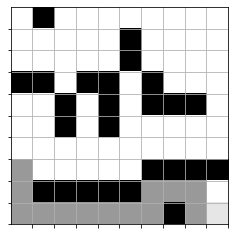

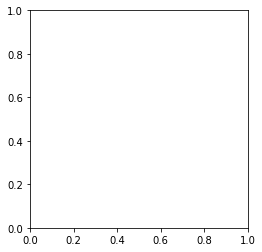

In [42]:
rat_cell = random.choice(qmaze.free_cells)
qmaze.reset(rat_cell)
envstate = qmaze.observe()
game_status = 'lose'
i=0
x = 7
q_v = []
env_s = []
while(game_status != 'win'):
    q = model.predict(envstate)
    if i>= x and i<3+x:
        q_v.append(q[0])
        env_s.append(envstate)
        
    action = np.argmax(q[0])
    #   action = np.argmax(model.predict(envstate))
    envstate, reward, game_status = qmaze.act(action)
    show(qmaze)
    display.clear_output(wait=True)
    display.display(pl.gcf())
    plt.gca().clear()
    sleep(0.2)
    i+=1

    Left         Up          Right       Down
[ 0.16977614 -0.1403308   0.5336234  -0.37354964]


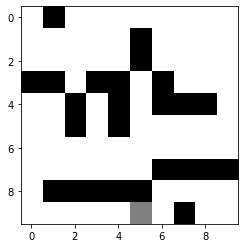

    Left         Up          Right       Down
[ 0.2814235   0.6327476  -0.539765   -0.50499475]


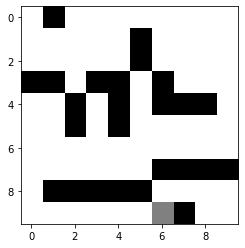

    Left         Up          Right       Down
[ 0.24167418  0.08761132  0.7425209  -0.40212566]


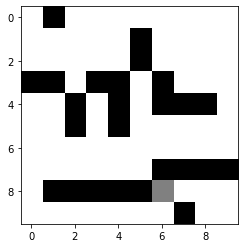

In [43]:
mapa= []
j=0
for k in range(3):
    m = np.zeros(maze.shape)
    for i in range(m.shape[0]):
        m[i] = env_s[k][0][j:j+m.shape[0]]
        j+=m.shape[0]
    mapa.append(m)
    j=0 
print('    Left         Up          Right       Down')
print(q_v[0])
plt.imshow(mapa[0], cmap = 'gray')
plt.show()
print('    Left         Up          Right       Down')
print(q_v[1])
plt.imshow(mapa[1], cmap = 'gray')
plt.show()
print('    Left         Up          Right       Down')
print(q_v[2])
plt.imshow(mapa[2], cmap = 'gray')
plt.show()